## Question (e)

(i) Derive the fomula.  

$p(\textbf{c}|\textbf{u}) = p(\textbf{c}|\mathbf{\theta}) = log[\prod_{i=1}^N p(c_i|\theta_i)] = \sum_{i=1}^N log(\frac{\theta_i^{c_i}e^{-\theta_i}}{c_i!})$  
So $p(\textbf{c}|\textbf{u}) = \sum_{i=1}^N -\theta_i+c_ilog(\theta_i)-log(c_i!)$.  

Then completed the $log\_poisson\_likelihood$ in function.py.

In [2]:
from functions import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

(ii) Generate samples from p(u|c).

In [22]:
### Read in the data
df = pd.read_csv('data.csv')

### Generate the arrays needed from the dataframe
data = np.array(df["bicycle.theft"])
xi = np.array(df['xi'])
yi = np.array(df['yi'])
N = len(data)
coords = [(xi[i],yi[i]) for i in range(N)]

### Subsample the original data set
subsample_factor = 4
idx = subsample(N, subsample_factor, seed=42)
G = get_G(N,idx)
c = G @ data

### Set MCMC parameters
l = 2
n = 10000
beta = 0.2

# Assume latent variables arise from Gaussian process
K = GaussianKernel(coords, l)
N = K.shape[0]
Kc = np.linalg.cholesky(K + 1e-6*np.eye(N))

### Set the likelihood and target, for sampling p(u|c)
log_target = log_poisson_target
log_likelihood = log_poisson_likelihood
u0 = Kc @ np.random.randn(N)

pcn_samples, acceptance_rate_pcn = pcn(log_likelihood, 
                                    u0 = u0, y = c, 
                                    K = K, G = G,
                                    n_iters = n, beta = beta)
pcn_samples = np.array(pcn_samples)

## Question(f)
(i) Using MC estimation:

$$
\begin{align*}
\mathbb{E}_{p(c^*|c)}[c^*] &= \sum_{k=0}^\infty k p(c^* = k | c) \\
&= \sum_{k=0}^\infty k \int p(c^* = k, u | c) \, du \\
&= \sum_{k=0}^\infty k \int p(c^* = k | u) p(u | c) \, du.
\end{align*}
$$

$$
\begin{align*}
\hat{c}^* &= \mathbb{E}_{p(c^*|c)}[c^*] \approx \frac{1}{n} \sum_{r=0}^\infty \sum_{j=1}^n r \, p(c^* = r | \tilde{u}^{(j)}) \\
&= \frac{1}{n} \sum_{j=1}^n \mathbb{E}_{p(c^* | u^{*(j)})}[c^*] \\
&= \frac{1}{n} \sum_{j=1}^n \mathbb{E}_{p(c^* | \theta^{*(j)})}[c^*] \\
&= \frac{1}{n} \sum_{j=1}^n \theta^{*(j)} \\
&= \frac{1}{n} \sum_{j=1}^n \exp(u^{*(j)}).
\end{align*}
$$

In [23]:
# Using MC to estimate
samples = pcn_samples
N = samples.shape[0]
M = samples.shape[1]  # Equal to dimension of sample
MC_sum = np.zeros(M)
for i in range(N):
    MC_sum += np.exp(samples[i, :])
MC_estimate = MC_sum/N  # Inferred expected counts


(ii) Visualisation:

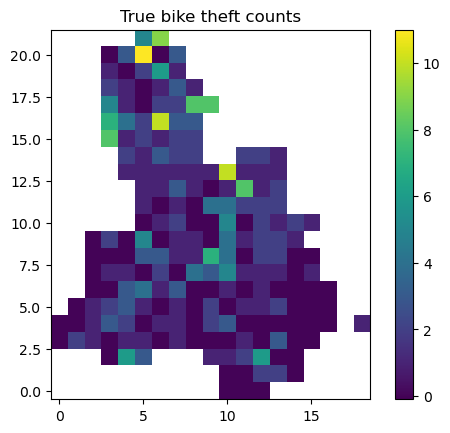

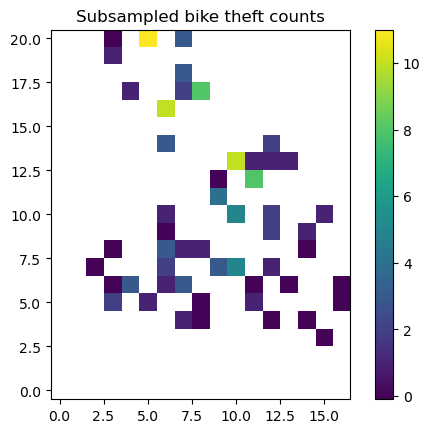

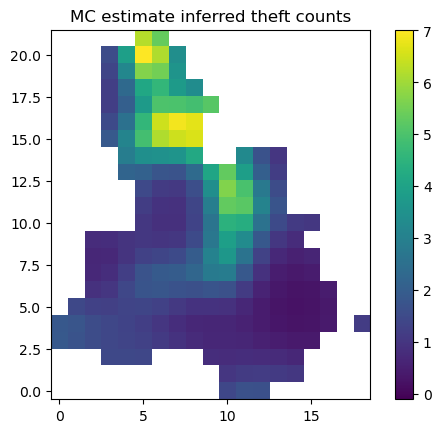

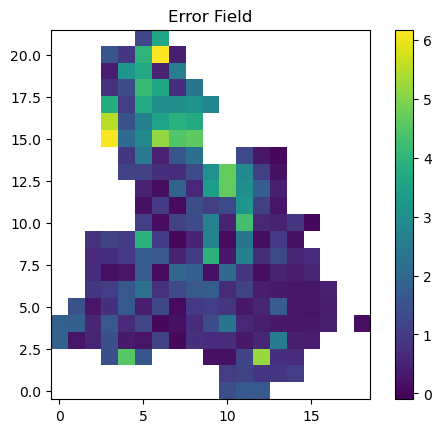

In [26]:
# original dataset
plot_2D(data, xi, yi, title="True bike theft counts")

# subsample dataset
plot_2D(c, xi[idx], yi[idx], title="Subsampled bike theft counts")

# MC Prediction
plot_2D(MC_estimate, xi, yi, title="MC estimate inferred theft counts")

# Error
plot_2D(np.abs(data-MC_estimate), xi, yi, title="Error Field")


plt.show()

(iii) extreme length-scale

In [32]:
ls= np.logspace(-2, 1,100)
Ks = [GaussianKernel(coords, l) for l in ls]
mean_pred_errors = np.zeros(100)

len(ls)

100

In [58]:
for i in range(len(ls)):
    N = Ks[i].shape[0]
    Kc = np.linalg.cholesky(Ks[i] + 1e-6 * np.eye(N))
    u0 = Kc @ np.random.randn(N)
    pcn_samples, acceptance_rate_pcn = pcn(log_poisson_likelihood, 
                                u0 = u0, y = c, 
                                K = Ks[i], G = G,
                                n_iters = n, beta = beta)
    pcn_samples = np.array(pcn_samples)

    # Using MC to estimate
    samples = pcn_samples
    N = samples.shape[0]
    M = samples.shape[1]  # Equal to dimension of sample
    MC_sum = np.zeros(M)
    for j in range(N):
        MC_sum += np.exp(samples[j, :])
    MC_estimate = MC_sum/N  # Inferred expected counts

    abs_error = np.abs(MC_estimate - data)
    mean_pred_errors[i] = np.mean(abs_error)

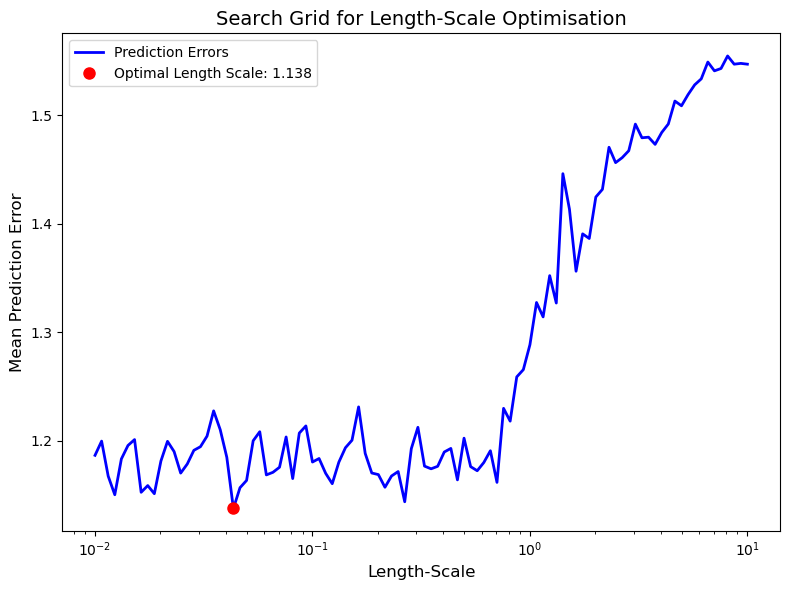

Minimum Prediction Error: 1.138


In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_pred_errors and ls are already defined
id = np.argmin(mean_pred_errors)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set axis labels and title
ax.set_xlabel("Length-Scale", fontsize=12)
ax.set_ylabel("Mean Prediction Error", fontsize=12)
ax.set_title("Search Grid for Length-Scale Optimisation", fontsize=14)

# Set x-axis to log scale
ax.set_xscale("log")

# Plot the prediction errors curve
ax.plot(ls, mean_pred_errors, label="Prediction Errors", color="b", linestyle='-', linewidth=2)

# Mark the minimum value in a different style (e.g., red dot)
ax.plot(ls[id], mean_pred_errors[id], 'ro', markersize=8, label=f"Optimal Length Scale: {mean_pred_errors[id]:.3f}")

# Add the legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Output the minimum prediction error
print(f"Minimum Prediction Error: {mean_pred_errors[id]:.3f}")


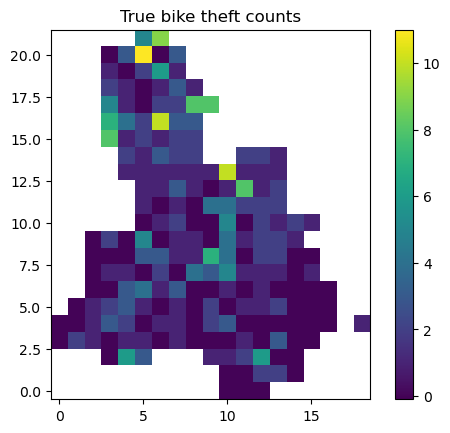

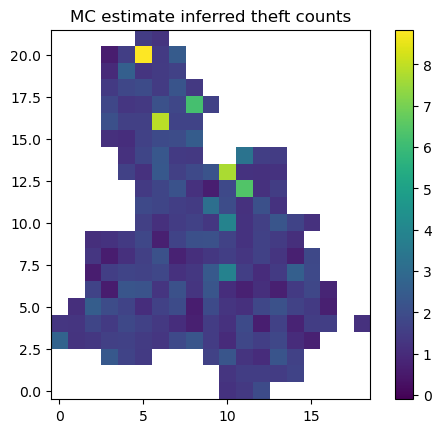

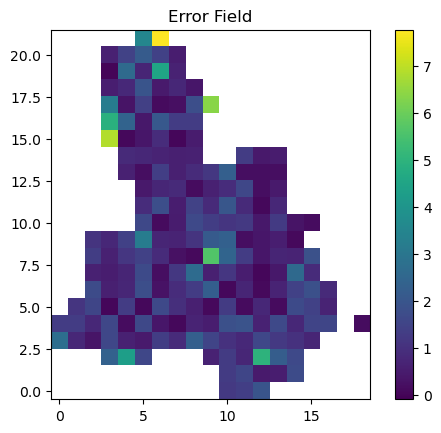

In [60]:
l_star = mean_pred_errors[id]

Kc = np.linalg.cholesky(Ks[id] + 1e-6 * np.eye(Ks[id].shape[0]))
u0 = Kc @ np.random.randn(Ks[id].shape[0])

pcn_samples, acceptance_rate_pcn = pcn(log_poisson_likelihood, 
                            u0 = u0, y = c, 
                            K = Ks[id], G = G,
                            n_iters = n, beta = beta)
pcn_samples = np.array(pcn_samples)

# Using MC to estimate
samples = pcn_samples
N = samples.shape[0]
M = samples.shape[1]  # Equal to dimension of sample
MC_sum = np.zeros(M)
for j in range(N):
    MC_sum += np.exp(samples[j, :])
MC_estimate = MC_sum/N  # Inferred expected counts

# abs_error = np.abs(MC_estimate - data)
# mean_pred_errors = np.mean(abs_error)

# original dataset
plot_2D(data, xi, yi, title="True bike theft counts")

# MC Prediction
plot_2D(MC_estimate, xi, yi, title="MC estimate inferred theft counts")

# Error
plot_2D(np.abs(data-MC_estimate), xi, yi, title="Error Field")

In [ ]:
# original dataset
plot_2D(data, xi, yi, title="True bike theft counts")

# subsample dataset
plot_2D(c, xi[idx], yi[idx], title="Subsampled bike theft counts")

# MC Prediction
plot_2D(MC_estimate, xi, yi, title="MC estimate inferred theft counts")

# Error
plot_2D(np.abs(data-MC_estimate), xi, yi, title="Error Field")

